## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
import random
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from time import time

## Load and setup

In [3]:
# path to matlab files
mats_folder = "/home/bug/TCC/datasets/db1t/"

# row limit display
pd.set_option('max_rows', 1000)

# import every .mat file
start_t = time()
mat_filenames = os.listdir(mats_folder)
mat_files = list()
for filename in mat_filenames:
    mat_files.append(loadmat(mats_folder + filename))
print("elapsed {:.4f}".format(time() - start_t))

# convert each mat file to a dict of pandas dataframes
start_t = time()
files = list()
for mat in mat_files:
    file = dict()
    for i, key in enumerate(mat):
        # display file contents
        shape = mat[key].shape if type(mat[key]) == np.ndarray else ""
        print("{0:<5} {1:<15} {2!s:<30} {3}".format(i, key, type(mat[key]), shape))
        # transform to pandas
        selected_keys = ['emg', 'subject', 'exercise', 'restimulus', 'rerepetition']
        if key in selected_keys:
            file.update({key: pd.DataFrame(mat[key])})     
    files.append(file)
print("elapsed {:.4f}".format(time() - start_t))

elapsed 0.2709
0     __header__      <class 'bytes'>                
1     __version__     <class 'str'>                  
2     __globals__     <class 'list'>                 
3     emg             <class 'numpy.ndarray'>        (142976, 10)
4     stimulus        <class 'numpy.ndarray'>        (142976, 1)
5     glove           <class 'numpy.ndarray'>        (142976, 22)
6     subject         <class 'numpy.ndarray'>        (1, 1)
7     exercise        <class 'numpy.ndarray'>        (1, 1)
8     repetition      <class 'numpy.ndarray'>        (142976, 1)
9     restimulus      <class 'numpy.ndarray'>        (142976, 1)
10    rerepetition    <class 'numpy.ndarray'>        (142976, 1)
elapsed 0.0012


## Functions

In [22]:
# return copy of a single movement
#todo: change to pass file instead of file_id
def get_movement(stim, rep, file):
    """
    Returns data from dataframe that matches given stimulus and repetition.
    If stim and rep are zero, returns every rest. 
    """
    bool_series = (file['restimulus'].loc[:,0] == stim) & (file['rerepetition'].loc[:,0] == rep)
    return file["emg"].loc[bool_series]

def get_waveformlength(series):
    """
    Return waveform length from a given series.
    """
    return abs(series.diff()).mean()

def df_window_apply_old(df, window_ms, shift_ms, func):
    freq = 100
    window_size = int((window_ms * freq) / 1000)
    shift_size = int((shift_ms * freq) / 1000)
    return df.rolling(window_size).apply(func, raw=False).dropna()[::shift_size]

# optimized
def df_window_apply(df, window_ms, shift_ms, func):
    """
    Apply given function to each dataframe column in a rolling window style.
    Returns dataframe where each line is a window result.
    """
    freq = 100
    window_size = int((window_ms * freq) / 1000)
    shift_size = int((shift_ms * freq) / 1000)
    
    n_samples = df.shape[0]
    n_shifts = int((n_samples-window_size)/shift_size)
    
    result_df = pd.DataFrame()
    
    if n_samples > window_size:
        actual_sample = window_size
        features = df.iloc[0:actual_sample, :].apply(func, raw=False)
        result_df = result_df.append(features, ignore_index=True)
        for _ in range(n_shifts):
            features = df.iloc[actual_sample:(actual_sample+shift_size), :].apply(func, raw=False)
            result_df = result_df.append(features, ignore_index=True)
            actual_sample = actual_sample + shift_size            
    return result_df

# nice looking confusion matrix
# ref: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Valor Real')
    plt.xlabel('Valor Predito')


## Preprocessing

In [29]:
# preparing data

ex1_stim_numbers = []
ex2_stim_numbers = [1, 6, 7, 13, 14]
ex3_stim_numbers = [1, 14, 17, 18, 21, 22]

df = pd.DataFrame()

for file_id, file in enumerate(files):
    start = time()
    
    # getting infos from file
    subj = file['subject'].squeeze()
    exercise = file['exercise'].squeeze()
    rep_numbers = file['rerepetition'].squeeze().unique()[1:]
    
    if exercise == 1:
        stim_numbers = ex1_stim_numbers
        offset = 0
    if exercise == 2:
        stim_numbers = ex2_stim_numbers
        offset = 12
    if exercise == 3:
        stim_numbers = ex3_stim_numbers
        offset = 12 + 17
    
    # getting features
    for stim in stim_numbers:
        for rep in rep_numbers:
            
            movement = get_movement(stim, rep, file)
            
            # Mean Absolute Value
            f1 = df_window_apply(movement, 250, 100, np.mean)
            
            # Waveform Length
            f2 = df_window_apply(movement, 250, 100, get_waveformlength)
            
            # join
            features = pd.concat([f1, f2], ignore_index=True, axis=1)
            
            # Meta Data
            features['y'] = stim+offset
            features['rep'] = rep
            features['subj'] = subj
            
            df = df.append(features, ignore_index=True)
            
    print("file_id: {}, elapsed {:.4f}".format(file_id, time() - start))

file_id: 0, elapsed 9.3077


In [27]:
### adding rest

# register next stimulus/repetition after rest (so we don't pollute our training with data all over)
df_prepared['rest_next_stim'] = 0
df_prepared['rest_next_rep'] = 0

for i, file in enumerate(files):
    start = time()
    
    # getting infos from file
    subj = file['subject'].squeeze()
    
    # split rest in groups (avoid tail/head linkage)
    movement = get_movement(0, 0, i)
    for group_ind, group in movement.groupby((movement.index.to_series().diff() > 1).cumsum()):

        ind_after_rest = group.index.max()+1
        
        # check if theres stimulus after rest (throw away rest without stimulus after)
        if file["restimulus"].index.max() >= ind_after_rest:
            # Mean Absolute Value
            a = df_window_apply(group, 250, 100, np.mean)

            # Waveform Length
            b = df_window_apply(group, 250, 100, get_waveformlength)

            # join
            features = pd.concat([a, b], ignore_index=True, axis=1)

            # Meta Data
            features['y'] = 0
            features['rep'] = 0
            features['subj'] = subj
            features['rest_next_stim'] = file["restimulus"].loc[ind_after_rest].squeeze()
            features['rest_next_rep'] = file["rerepetition"].loc[ind_after_rest].squeeze()

            df_prepared = df_prepared.append(features, ignore_index=True)

    print("file_id: {}, elapsed {:.4f}".format(i, time() - start))

file_id: 0, elapsed 59.3552


## Training / Validating

In [18]:
# train 1 vs 1
# reps [9, 10] == validation

#subjects = [10,] # debug
test_subjects = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]
subjects = [23,24,25,26,27]  # do not use

# for accuracy metrics
train_acc = list()
val_acc = list()

# for confusion matrix
y_val_total = list()
y_val_predictions_total = list()


for subject in subjects:
    start = time()

    # data split
    
    # select data
    train_reps = [1, 2, 3, 4, 5, 6, 7, 8]
    val_reps = [9, 10]  # 2 reps to be validation
    
    # add stimulus
    df_train = df_prepared.loc[(df_prepared.subj == subject) & df_prepared.rep.isin(train_reps)]
    df_val   = df_prepared.loc[(df_prepared.subj == subject) & df_prepared.rep.isin(val_reps)]
    
    # add rest
    df_rest_train = df_prepared.loc[(df_prepared.subj == subject) & df_prepared.rest_next_rep.isin(train_reps)]
    df_rest_val = df_prepared.loc[(df_prepared.subj == subject) & df_prepared.rest_next_rep.isin(val_reps)]
     
    df_train = df_train.append(df_rest_train, ignore_index=True)
    df_val = df_val.append(df_rest_val, ignore_index=True)
    
    # prepare for training
    x_train  = df_train.drop(columns=['rep', 'subj', 'y', 'rest_next_stim', 'rest_next_rep'])
    y_train  = df_train.y

    x_val    = df_val.drop(columns=['rep', 'subj', 'y', 'rest_next_stim', 'rest_next_rep'])
    y_val    = df_val.y

    # scaling
    scaler = StandardScaler().fit(x_train)
    x_train = scaler.transform(x_train)
    x_val = scaler.transform(x_val)

    # model training
    mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=10000, shuffle=True)
    mlp.fit(x_train, y_train)
    
    ### PICKLE DUMP
    pickle.dump(mlp, open('trained_model_test_' + str(subject) +'.pck', 'wb'))
    pickle.dump(scaler, open('scaler_test_'+ str(subject) + '.pck', 'wb'))
    
    # predict
    train_predictions = mlp.predict(x_train)
    train_acc.append(accuracy_score(y_train, train_predictions))

    y_val_predictions = mlp.predict(x_val)
    val_acc.append(accuracy_score(y_val, y_val_predictions))
    
    # for confusion matrix
    y_val_total = y_val_total + list(y_val)
    y_val_predictions_total = y_val_predictions_total + list(y_val_predictions)
    
    print("subj {} elapsed {:.4f}".format(subject, time() - start))
    

subj 23 elapsed 22.6351
subj 24 elapsed 23.1643
subj 25 elapsed 21.6299
subj 26 elapsed 11.4272
subj 27 elapsed 18.7347


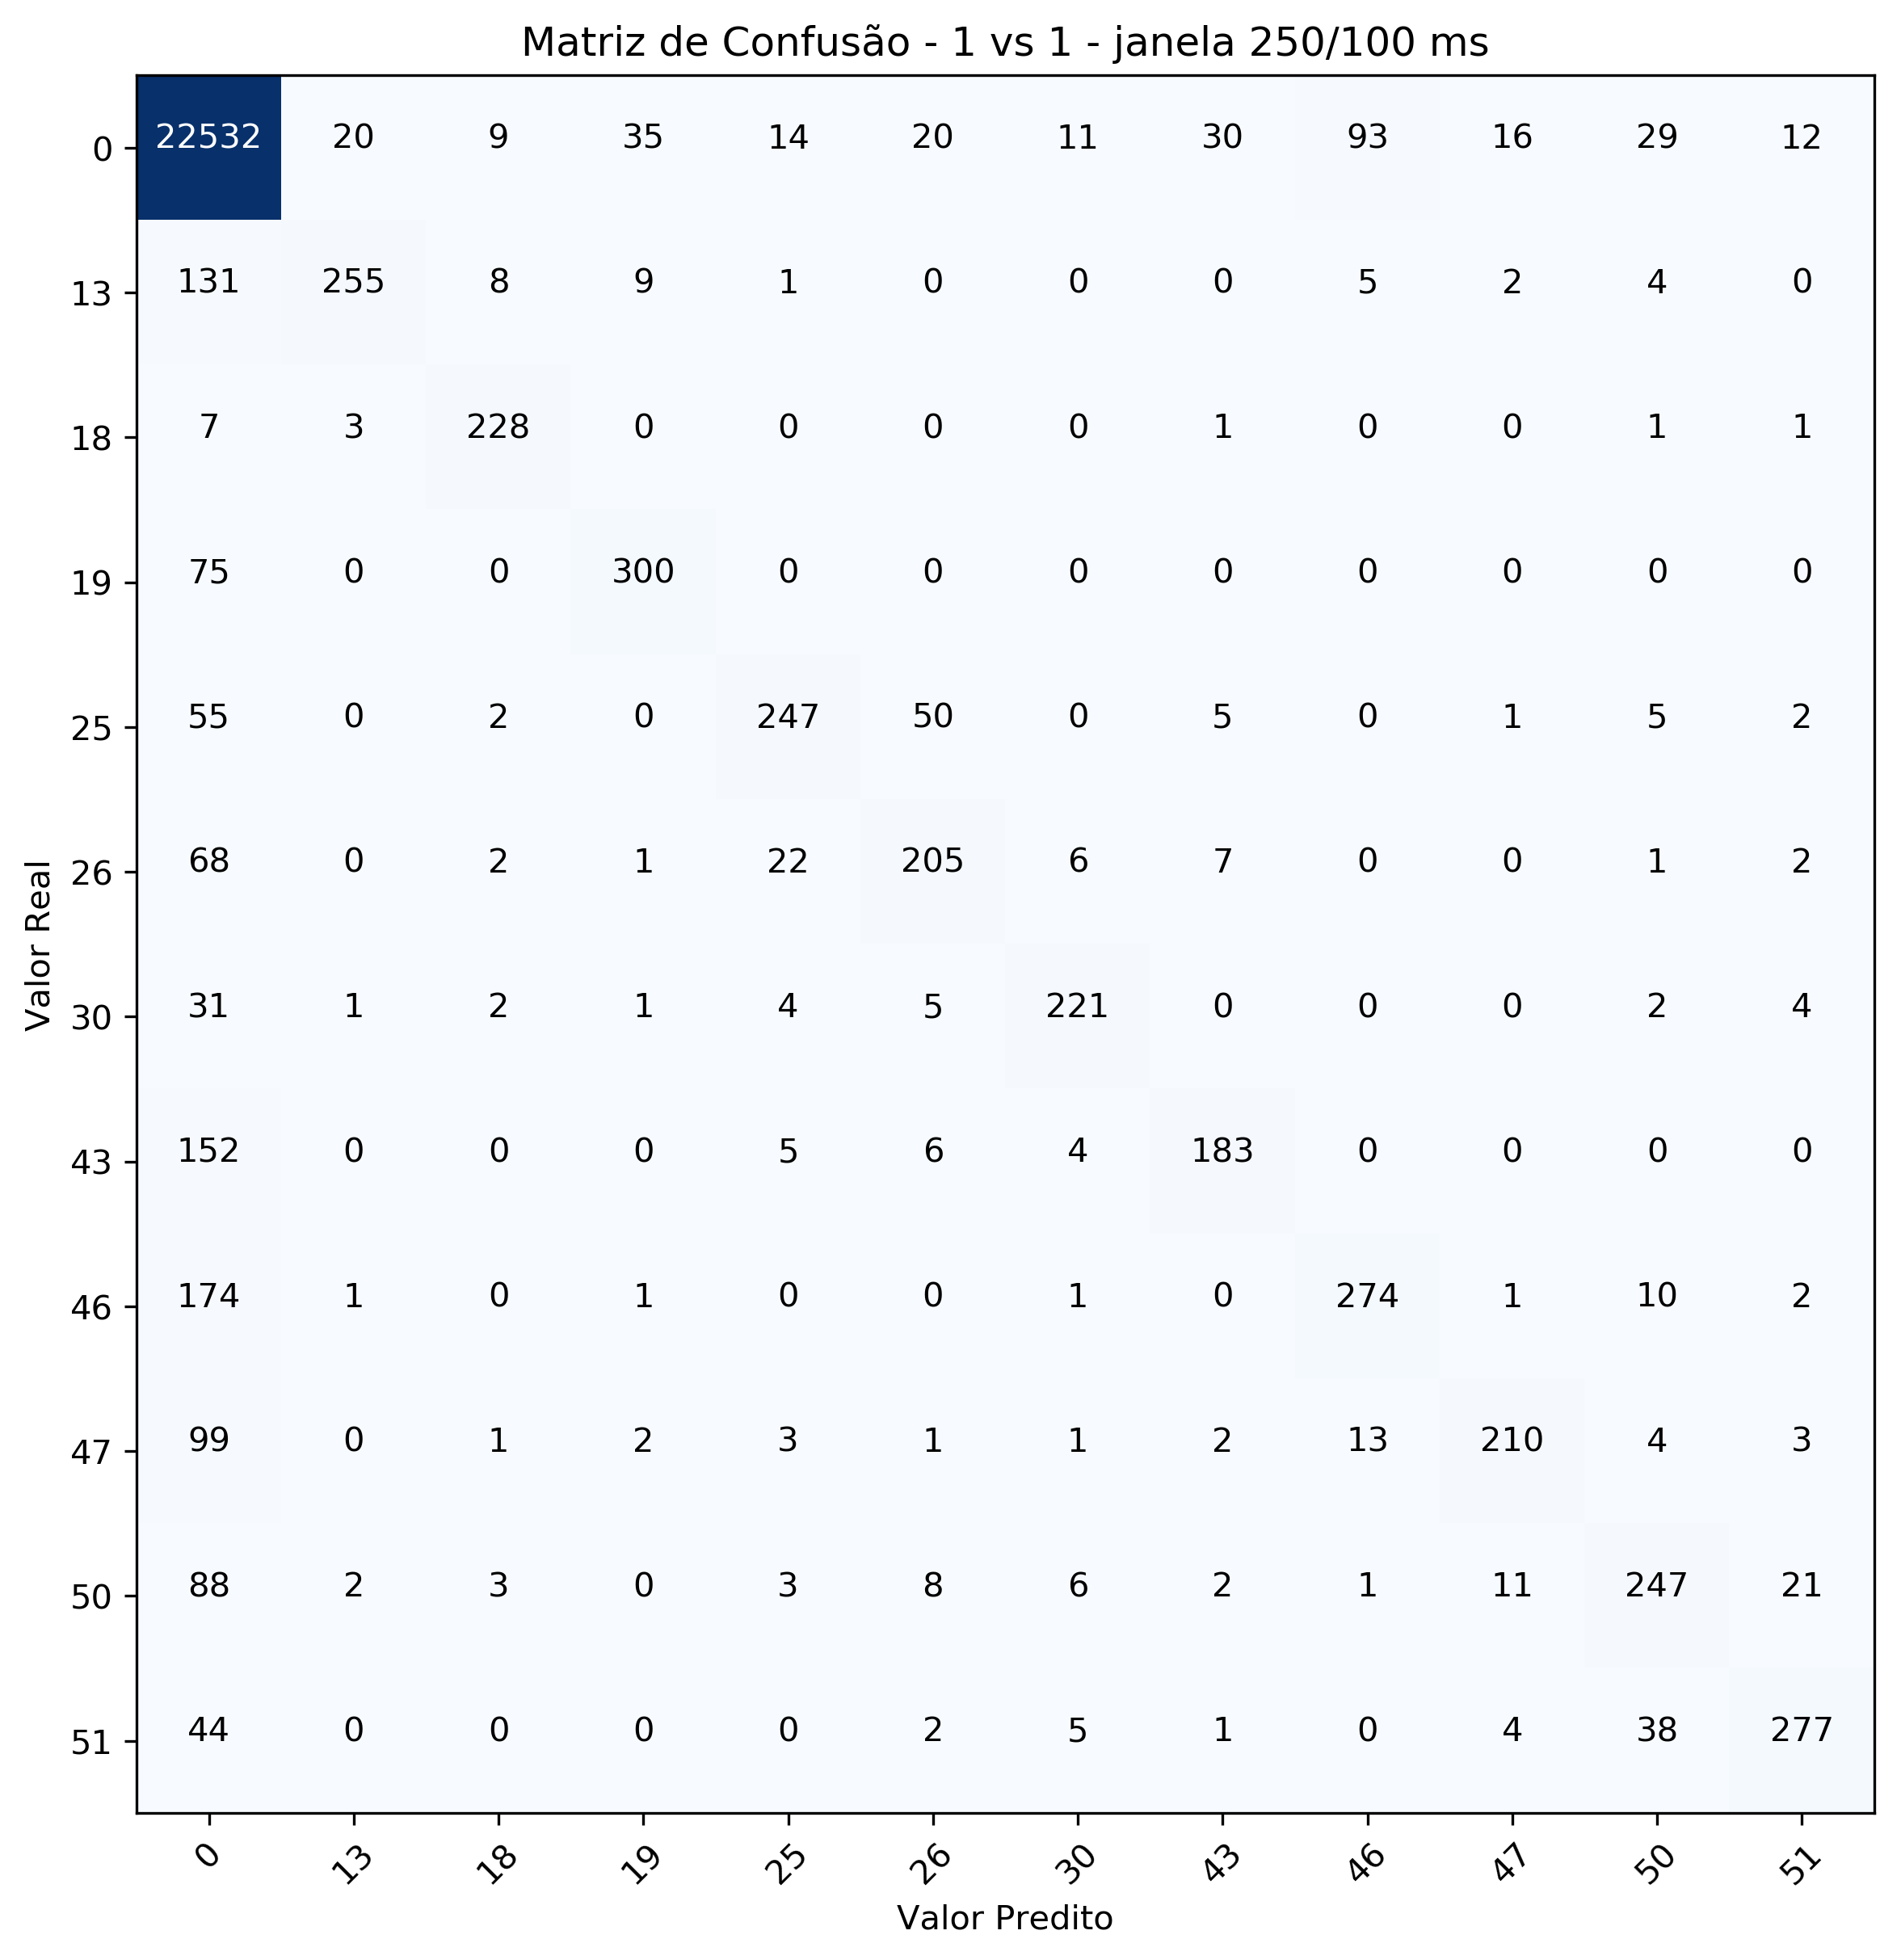

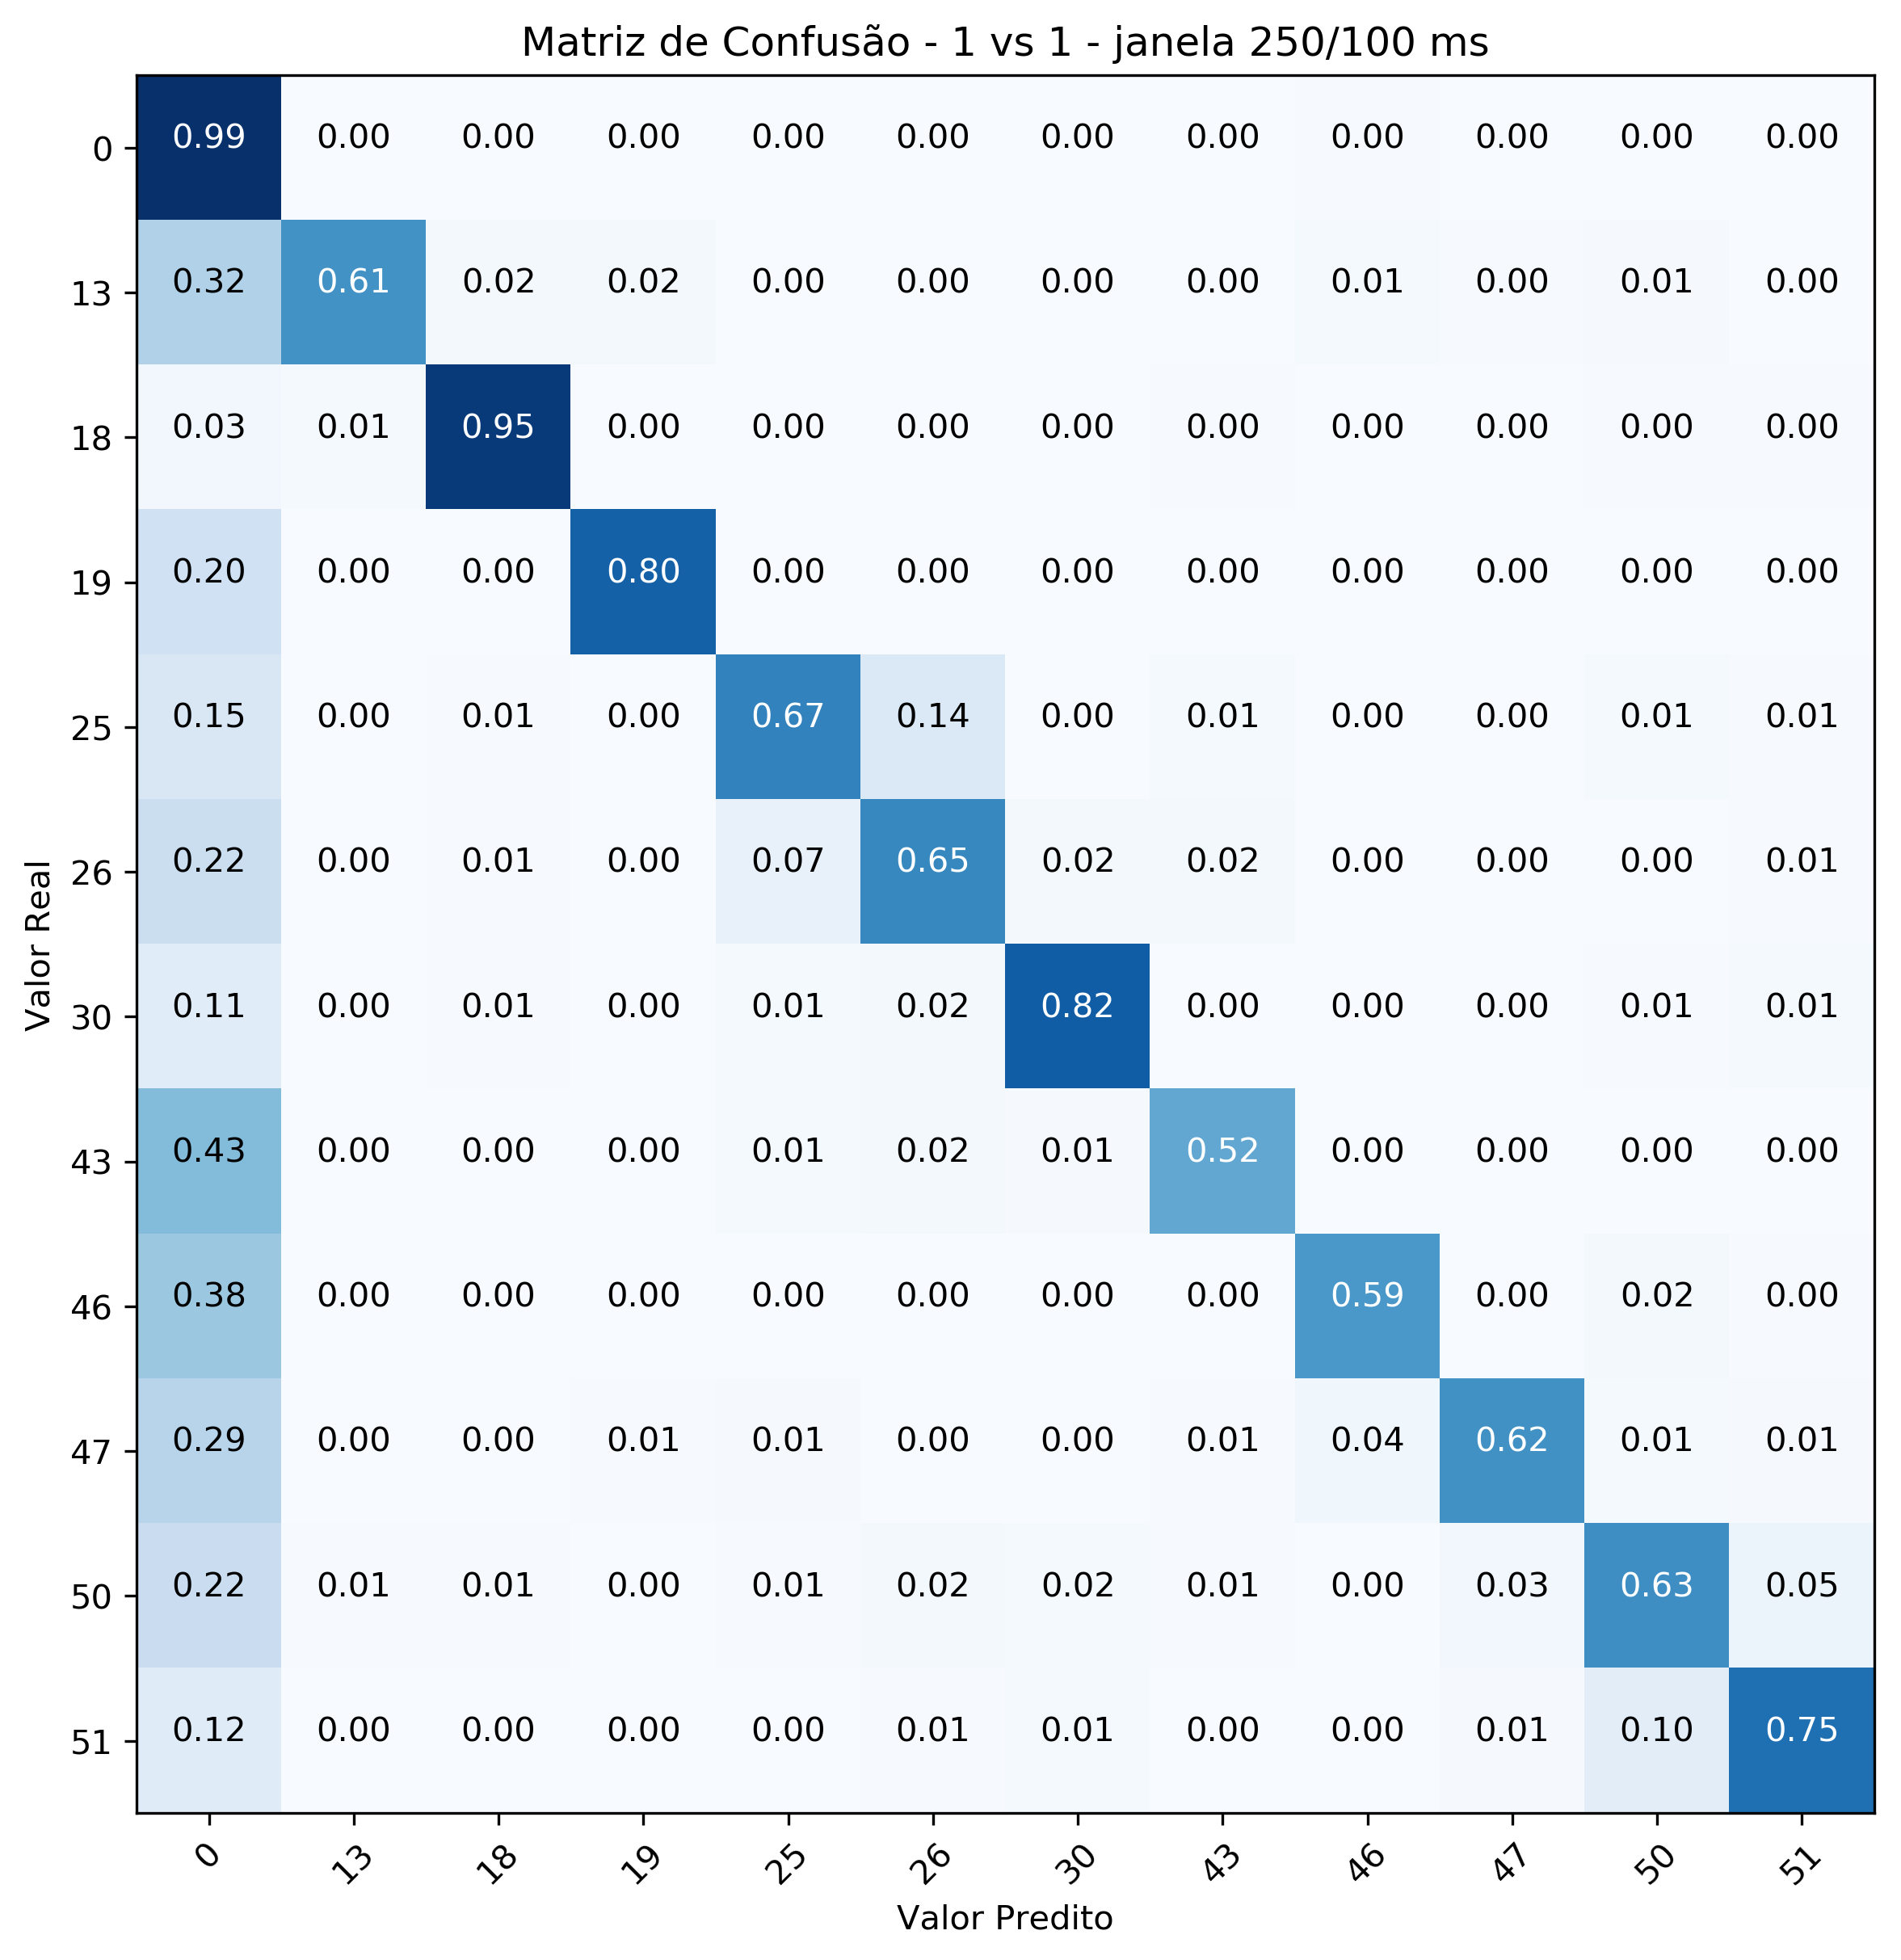

In [13]:
# Compute confusion matrix

cnf_matrix = confusion_matrix(y_val_total, y_val_predictions_total)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 8), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=np.sort(df_prepared.y.unique()),
                      title='Matriz de Confusão - 1 vs 1 - janela 250/100 ms')
plt.show()

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_val_total, y_val_predictions_total)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
fig = plt.figure(figsize=(8, 8), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=np.sort(df_prepared.y.unique()),
                      title='Matriz de Confusão - 1 vs 1 - janela 250/100 ms', normalize=True)
plt.show()

In [14]:
fig.savefig("test_confusion_matrix")

In [15]:
plt.close(fig)

In [11]:
print('train accuracy:', np.mean(train_acc))
print('validation accuracy:', np.mean(val_acc))

train accuracy: 0.9757406909412369
validation accuracy: 0.9411494030938916


In [12]:
print(classification_report(y_val_total, y_val_predictions_total))

             precision    recall  f1-score   support

          0       0.96      0.99      0.97     22821
         13       0.90      0.61      0.73       415
         18       0.89      0.95      0.92       241
         19       0.86      0.80      0.83       375
         25       0.83      0.67      0.74       367
         26       0.69      0.65      0.67       314
         30       0.87      0.82      0.84       271
         43       0.79      0.52      0.63       350
         46       0.71      0.59      0.64       464
         47       0.86      0.62      0.72       339
         50       0.72      0.63      0.67       392
         51       0.85      0.75      0.80       371

avg / total       0.94      0.94      0.94     26720



In [16]:
# save the model to disk
import pickle
